In [35]:
# Add these at the top of your notebook cell
import matplotlib
matplotlib.use('inline')  # or 'Agg'
import matplotlib.pyplot as plt
plt.ion()  # Turn on interactive mode

# Also add this to force display
%matplotlib inline
import torchvision.transforms.v2 as T

In [36]:
def get_imc_transforms(image_size=(256, 256)):
    train_transform = T.Compose([
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.RandomRotation([0,360]),
        T.RandomAffine(degrees=0, translate=(0.05, 0.05)),
        T.Resize(image_size, antialias=True),
    ])
    val_transform = T.Compose([
        T.Resize(image_size, antialias=True),
    ])
    return train_transform, val_transform

In [37]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from pathlib import Path
import tifffile
from typing import Tuple, Optional, List, Dict
import logging
import re

class IMCDataset(Dataset):
    """Dataset for IMC (Imaging Mass Cytometry) data for tissue type and condition prediction"""
    
    def __init__(
        self,
        data_dir: str,
        transform=None,
        target_transform=None,
        use_mask: bool = False,
        channels: Optional[List[int]] = None,
        image_size: Optional[Tuple[int, int]] = None,
        normalize: bool = True,
        arcsinh_transform: bool = True,
        cofactor: float = 5.0,
        classification_task: str = "condition",  # "condition" (Benign vs Malignant) - "tissue" and "both" removed since we only have prostate data
        split: str = "train"
    ):
        """
        Args:
            data_dir: Directory containing ROI folders
            transform: Optional transform to be applied on images
            target_transform: Optional transform to be applied on labels
            use_mask: Whether to use the mask.tiff files
            channels: List of channel indices to use (if None, uses all)
            image_size: Size to resize images to (height, width)
            normalize: Whether to normalize channels
            arcsinh_transform: Whether to apply arcsinh transformation
            cofactor: Cofactor for arcsinh transformation
            classification_task: What to predict - "tissue", "condition", or "both"
        """
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.target_transform = target_transform
        self.use_mask = use_mask
        self.channels = channels
        self.image_size = image_size
        self.normalize = normalize
        self.arcsinh_transform = arcsinh_transform
        self.cofactor = cofactor
        self.classification_task = classification_task
        
        # Scan directory and parse folder names
        self.samples = self._scan_directory()
        
        # Create label mappings based on classification task
        self._create_label_mappings()
        
        logging.info(f"Loaded {len(self.samples)} samples")
        logging.info(f"Classification task: {self.classification_task}")
        logging.info(f"Labels: {self.unique_labels}")

        # Set transforms if not provided
        if transform is None and image_size is not None:
            train_transform, val_transform = get_imc_transforms(image_size)
            self.transform = train_transform if split == "train" else val_transform
        else:
            self.transform = transform
        
    def _scan_directory(self):
        """Scan directory for ROI folders and parse information"""
        samples = []
        
        for roi_folder in self.data_dir.glob("ROI*"):
            if not roi_folder.is_dir():
                continue
                
            # Parse folder name: ROI###_TISSUE_[Benign_]TMA###[N]
            folder_name = roi_folder.name
            
            # Extract ROI number
            roi_match = re.match(r"ROI(\d+)", folder_name)
            if not roi_match:
                continue
            roi_num = int(roi_match.group(1))
            
            # Extract tissue type
            parts = folder_name.split('_')
            if len(parts) < 3:
                continue
            tissue = parts[1]  # PROSTATE, LIVER, KIDNEY
            
            # Determine if benign or malignant
            if "Benign" in folder_name:
                condition = "Benign"
            else:
                condition = "Malignant"
            
            # Check if image files exist
            imc_path = roi_folder / "input" / "imc"
            if not imc_path.exists():
                continue
                
            # Look for .ome.tiff file
            ome_files = list(imc_path.glob("*.ome.tiff"))
            if not ome_files:
                continue
            image_file = ome_files[0]
            
            # Look for mask file if needed
            mask_file = None
            if self.use_mask:
                mask_files = list(imc_path.glob("*_mask.tiff"))
                if mask_files:
                    mask_file = mask_files[0]
            
            samples.append({
                'roi_num': roi_num,
                'tissue': tissue,
                'condition': condition,
                'folder_name': folder_name,
                'image_path': image_file,
                'mask_path': mask_file,
                'roi_folder': roi_folder
            })
        
        return samples
    
    def _create_label_mappings(self):
        """Create label mappings based on classification task"""
        if self.classification_task == "tissue":
            labels = [sample['tissue'] for sample in self.samples]
        elif self.classification_task == "condition":
            labels = [sample['condition'] for sample in self.samples]
        elif self.classification_task == "both":
            labels = [f"{sample['tissue']}_{sample['condition']}" for sample in self.samples]
        else:
            raise ValueError("classification_task must be 'tissue', 'condition', or 'both'")
        
        self.unique_labels = sorted(list(set(labels)))
        self.label_to_idx = {label: idx for idx, label in enumerate(self.unique_labels)}
        self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        # Load image
        image = self._load_image(sample['image_path'])
        
        # Load mask if needed
        mask = None
        if self.use_mask and sample['mask_path']:
            mask = self._load_mask(sample['mask_path'])
        
        # Get label based on classification task
        if self.classification_task == "tissue":
            label = sample['tissue']
        elif self.classification_task == "condition":
            label = sample['condition']
        elif self.classification_task == "both":
            label = f"{sample['tissue']}_{sample['condition']}"
        
        label_idx = self.label_to_idx[label]
        
        # Apply transforms
        if self.transform:
            print(" Applying transform")
            image = self.transform(image)
        
        if self.target_transform:
            label_idx = self.target_transform(label_idx)
        
        if mask is not None:
            return image, label_idx, mask
        else:
            return image, label_idx
    
    def _load_image(self, img_path: Path) -> torch.Tensor:
        """Load and preprocess IMC image"""
        # Load OME-TIFF image
        img = tifffile.imread(str(img_path))
        
        # Ensure image is float32
        img = img.astype(np.float32)
        
        # Handle different image shapes
        if img.ndim == 2:
            # Single channel image
            img = img[np.newaxis, ...]  # Add channel dimension
        elif img.ndim == 3:
            # Multi-channel image - OME-TIFF usually has channels first
            # If channels are last, transpose
            if img.shape[2] < img.shape[0]:
                img = np.transpose(img, (2, 0, 1))
        
        # Select specific channels if specified
        if self.channels is not None:
            img = img[self.channels]
        
        # Apply arcsinh transformation (common for mass cytometry data)
        if self.arcsinh_transform:
            img = np.arcsinh(img / self.cofactor)
        
        # Normalize each channel
        if self.normalize:
            for c in range(img.shape[0]):
                channel = img[c]
                if channel.std() > 0:
                    img[c] = (channel - channel.mean()) / channel.std()
        
        # Resize if needed
        if self.image_size is not None and self.image_size != img.shape[1:]:
            img = torch.nn.functional.interpolate(
                torch.from_numpy(img).unsqueeze(0),
                size=self.image_size,
                mode='bilinear',
                align_corners=False
            ).squeeze(0).numpy()
        
        return torch.from_numpy(img)
    
    def _load_mask(self, mask_path: Path) -> torch.Tensor:
        """Load segmentation mask"""
        mask = tifffile.imread(str(mask_path))
        return torch.from_numpy(mask.astype(np.int64))
    
    def get_class_weights(self):
        """Calculate class weights for imbalanced datasets"""
        if self.classification_task == "tissue":
            labels = [sample['tissue'] for sample in self.samples]
        elif self.classification_task == "condition":
            labels = [sample['condition'] for sample in self.samples]
        elif self.classification_task == "both":
            labels = [f"{sample['tissue']}_{sample['condition']}" for sample in self.samples]
        
        from collections import Counter
        label_counts = Counter(labels)
        total_samples = len(self.samples)
        
        weights = []
        for label in self.unique_labels:
            weight = total_samples / (len(self.unique_labels) * label_counts[label])
            weights.append(weight)
        
        return torch.FloatTensor(weights)


def create_dataloaders(
    data_dir: str,
    train_split: float = 0.8,
    batch_size: int = 32,
    num_workers: int = 4,
    pin_memory: bool = True,
    random_seed: int = 42,
    **dataset_kwargs
) -> Tuple[DataLoader, DataLoader, Dict]:
    """Create training and validation dataloaders from a single directory"""
    
    # Create full dataset
    full_dataset = IMCDataset(
        data_dir=data_dir,
        **dataset_kwargs
    )
    
    # Check if we have any samples left after filtering
    if len(full_dataset) == 0:
        raise ValueError("No valid samples found after filtering single-sample classes")
    
    # For condition classification with filtered data, we can do stratified split
    try:
        from sklearn.model_selection import train_test_split
        
        # Get labels for stratification
        if full_dataset.classification_task == "tissue":
            labels = [sample['tissue'] for sample in full_dataset.samples]
        elif full_dataset.classification_task == "condition":
            labels = [sample['condition'] for sample in full_dataset.samples]
        else:
            labels = [f"{sample['tissue']}_{sample['condition']}" for sample in full_dataset.samples]
        
        # Try stratified split
        indices = list(range(len(full_dataset)))
        train_idx, val_idx = train_test_split(
            indices, 
            train_size=train_split,
            stratify=labels,
            random_state=random_seed
        )
        
        train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
        val_dataset = torch.utils.data.Subset(full_dataset, val_idx)
        
        print("✅ Using stratified split (ensures each class in both train/val)")
        
    except (ImportError, ValueError) as e:
        # Fall back to random split if sklearn not available or stratification fails
        print(f"⚠️ Stratified split failed ({e}), using random split")
        torch.manual_seed(random_seed)
        train_size = int(train_split * len(full_dataset))
        val_size = len(full_dataset) - train_size
        
        # Stratified split
        train_dataset = torch.utils.data.Subset(
            IMCDataset(data_dir=data_dir, split="train", **dataset_kwargs), train_idx
        )
        val_dataset = torch.utils.data.Subset(
            IMCDataset(data_dir=data_dir, split="val", **dataset_kwargs), val_idx
        )

    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory,
        drop_last=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory,
        drop_last=False
    )
    
    # Get dataset info
    dataset_info = {
        'num_classes': len(full_dataset.unique_labels),
        'class_names': full_dataset.unique_labels,
        'class_weights': full_dataset.get_class_weights(),
        'train_size': len(train_dataset),
        'val_size': len(val_dataset),
        'total_samples': len(full_dataset),
        'classification_task': full_dataset.classification_task
    }
    
    # Print summary
    print(f"📊 Dataset Summary:")
    print(f"   Classification task: {dataset_info['classification_task']}")
    print(f"   Classes: {dataset_info['class_names']}")
    print(f"   Total samples: {dataset_info['total_samples']}")
    print(f"   Train samples: {dataset_info['train_size']}")
    print(f"   Val samples: {dataset_info['val_size']}")
    
    return train_loader, val_loader, dataset_info


# Example usage
if __name__ == "__main__":
    # Simplified example for prostate cancer classification
    train_loader, val_loader, dataset_info = create_dataloaders(
        data_dir="./data",  # Your symlinked data directory
        classification_task="condition",  # Benign vs Malignant (recommended)
        batch_size=16,
        use_mask=False,  # Set to True if you want to use segmentation masks
        channels=None,  # Use all channels, or specify subset like [0, 5, 10]
        image_size=(256, 256),  # Resize images
        arcsinh_transform=True,
        cofactor=5.0,
        train_split=0.8
    )
    
    print(f"🎯 Prostate Cancer Classification Setup")
    print(f"Classes: {dataset_info['class_names']}")  # Should be ['Benign', 'Malignant']
    print(f"Train samples: {dataset_info['train_size']}")
    print(f"Val samples: {dataset_info['val_size']}")
    
    # Test the dataloader
    for batch_idx, (images, labels) in enumerate(train_loader):
        print(f"Batch {batch_idx}: Images shape: {images.shape}, Labels: {labels}")
        # Decode labels to see class names
        label_names = [dataset_info['class_names'][label.item()] for label in labels]
        print(f"Label names: {label_names}")
        if batch_idx == 0:
            break

✅ Using stratified split (ensures each class in both train/val)
📊 Dataset Summary:
   Classification task: condition
   Classes: ['Benign', 'Malignant']
   Total samples: 63
   Train samples: 50
   Val samples: 13
🎯 Prostate Cancer Classification Setup
Classes: ['Benign', 'Malignant']
Train samples: 50
Val samples: 13
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
Image shape: torch.Size([62, 256, 256])


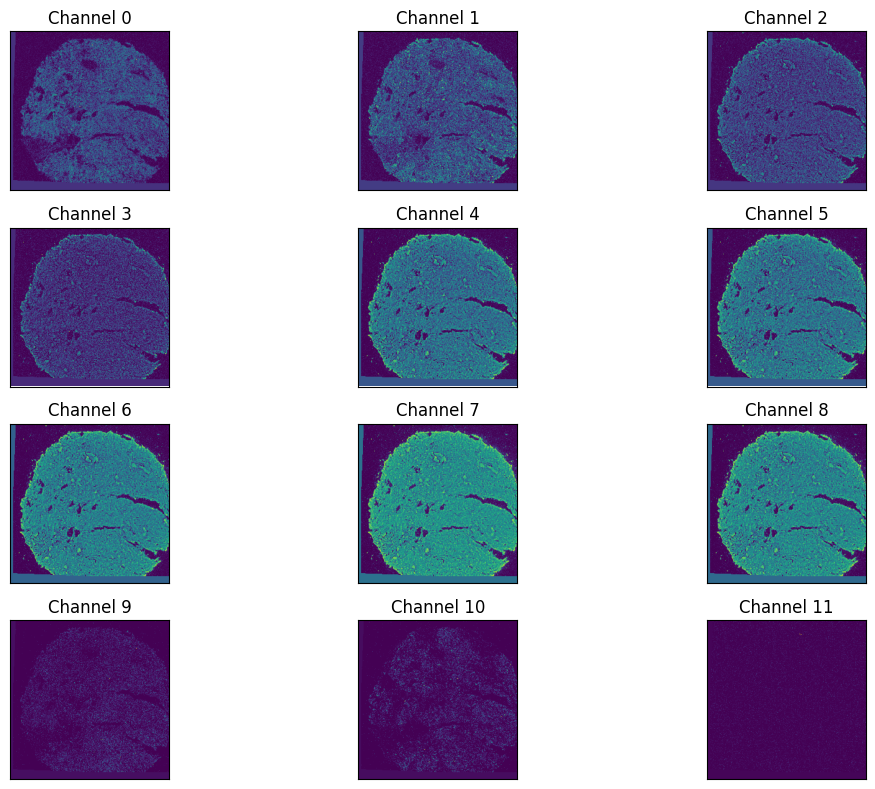

In [38]:
# Get one batch and visualize just one image
for batch_idx, (images, labels) in enumerate(train_loader):
    # Get first image
    first_image = images[0]  # Shape: (62, 128, 128)
    first_label = labels[0].item()
    
    print(f"Image shape: {first_image.shape}")
    print(f"Label: {first_label} ({dataset_info['class_names'][first_label]})")
    
    # Show first 6 channels
    fig, axes = plt.subplots(4, 3, figsize=(12, 8))
    axes = axes.flatten()
    
    for i in range(12):
        channel_data = first_image[i].numpy()
        im = axes[i].imshow(channel_data, cmap='viridis')
        axes[i].set_title(f'Channel {i}')
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    
    plt.tight_layout()
    plt.show()
    break

In [51]:
from sympy import Ge
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.ops import DropBlock2d
import torchvision.transforms as transforms
import torchvision.datasets as dataset
import torch.nn.functional as F
import torchvision.models as models
from typing import List, Tuple, Optional


class ConvNeXtMarkerEncoder(nn.Module):  # Added nn.Module inheritance
    "ConvNeXt - based marker encoder for individual IMC marker channels"
    def __init__(self, feature_dim: int = 128, convnext_type: str = 'convnext_tiny', pretrained: bool = True, dropout_rate: float = 0.3):
        super(ConvNeXtMarkerEncoder, self).__init__()
        self.feature_dim = feature_dim
        #load the pretrained model
        if convnext_type == "convnext_tiny":
            self.backbone = models.convnext_tiny(weights='ConvNeXt_Tiny_Weights.DEFAULT')
            backbone_out_features = 768
        elif convnext_type == "convnext_small":
            self.backbone = models.convnext_small(pretrained=pretrained)
            backbone_out_features = 768
        elif convnext_type == "convnext_base":
            self.backbone = models.convnext_base(pretrained=pretrained)
            backbone_out_features = 1024
        elif convnext_type == "convnext_large":
            self.backbone = models.convnext_large(pretrained=pretrained)
            backbone_out_features = 1536
        else:
            raise ValueError(f"Invalid ConvNeXt type: {convnext_type}. Expected one of: convnext_tiny, convnext_small, convnext_base, convnext_large")

        #modify the first layer to accept a single channel input
        original_first_conv = self.backbone.features[0][0]
        self.backbone.features[0][0] = nn.Conv2d(  # type: ignore
            in_channels=1,
            out_channels=original_first_conv.out_channels,  # type: ignore
            kernel_size=original_first_conv.kernel_size,  # type: ignore
            stride=original_first_conv.stride,  # type: ignore
            padding=original_first_conv.padding,  # type: ignore
            bias=False
        )
        #remove final classification layers
        self.backbone.classifier = nn.Identity()  # type:ignore

        #adding custom feature head
        self.feature_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.LayerNorm(backbone_out_features),
            nn.Linear(backbone_out_features, 512),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, feature_dim),
            nn.GELU(),
            nn.Dropout(dropout_rate)
        )

    def forward(self, X):  # Fixed indentation
        # x shape: [batch_size, 1, H, W]
        features = self.backbone(X)
        features = self.feature_head(features)
        return features


class AttentionFusionHead(nn.Module):
    def __init__(self, feature_dim=128, num_markers=62, num_classes=2, num_attention_heads=4, dropout_rate=0.3, use_cross_attention=False):
        super(AttentionFusionHead, self).__init__()
        self.feature_dim = feature_dim
        self.num_markers = num_markers
        self.num_classes = num_classes
        self.use_cross_attention = use_cross_attention

        #Multi head self interaction for marker interaction
        self.self_attention = nn.MultiheadAttention(
            embed_dim=feature_dim,
            num_heads=num_attention_heads,
            dropout=dropout_rate,
            batch_first=True
        )
        #cross attention(not implementing for now)
        if use_cross_attention:
            self.cross_attention = nn.MultiheadAttention(
                embed_dim=feature_dim,
                num_heads=num_attention_heads,
                dropout=dropout_rate,
                batch_first=True
            )
        #Layer Normalization
        self.norm1 = nn.LayerNorm(feature_dim)
        self.norm2 = nn.LayerNorm(feature_dim)
        if use_cross_attention:
            self.norm3 = nn.LayerNorm(feature_dim)

        #Feed forward Network (Convnext inspired)
        self.ffn = nn.Sequential(
            nn.Linear(feature_dim, feature_dim * 2),  # Reduced for memory
            nn.GELU(),  # ConvNeXt uses GELU
            nn.Dropout(dropout_rate),
            nn.Linear(feature_dim * 2, feature_dim),
            nn.Dropout(dropout_rate)
        )
        self.marker_importance = nn.Sequential(
            nn.Linear(feature_dim, feature_dim//2),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(feature_dim//2, 1)
        )

        self.classifier = nn.Sequential(
            nn.LayerNorm(feature_dim),
            nn.Linear(feature_dim, 256),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, marker_features):
        #marker features = [batch_size,num_markers,feature_dim]
        batch_size = marker_features.size(0)
        #self attention to catch marker interaction
        attended_features, self_attention_weights = self.self_attention(
            marker_features, marker_features, marker_features
        )
        #residual connection+ normalization
        attended_features = self.norm1(marker_features + attended_features)

        #optional cross attention
        cross_attention_weights = None
        if self.use_cross_attention:
            cross_attended, cross_attention_weights = self.cross_attention(
                attended_features, attended_features, attended_features
            )
            attended_features = self.norm2(attended_features + cross_attended)

        #Feed forward network with residual connection
        ffn_output = self.ffn(attended_features)
        if self.use_cross_attention:
            attended_features = self.norm3(attended_features + ffn_output)
        else:
            attended_features = self.norm2(attended_features + ffn_output)
        #calvulaate marker important scores
        importance_logits = self.marker_importance(attended_features).squeeze(-1)
        importance_weights = F.softmax(importance_logits, 1)  # [batch size, num workers
        
        #weighted pooling based on importance
        pooled_features = torch.sum(
            attended_features * importance_weights.unsqueeze(-1),
            dim=1
            #[batch size,feature_dim]
        )
        #final classification
        logits = self.classifier(pooled_features)
        return {
            'logits': logits,
            'self_attention_weights': self_attention_weights,
            'cross_attention_weights': cross_attention_weights,
            'marker_importance': importance_weights,
            'pooled_features': pooled_features,
            'attended_features': attended_features
        }


class IMCClassifier(nn.Module):
    def __init__(
            self,
            num_markers=62,
            feature_dim=128,
            num_classes=2,
            convnext_type='convnext_tiny',
            pretrained=True,
            num_attention_heads=4,
            dropout_rate=0.3,
            shared_backbone=True,
            use_cross_attention=False
    ):
        super(IMCClassifier, self).__init__()
        self.num_markers = num_markers
        self.feature_dim = feature_dim
        self.shared_backbone = shared_backbone
        self.convnext_type = convnext_type

        #create the encoder
        if shared_backbone:
            self.marker_encoder = ConvNeXtMarkerEncoder(
                feature_dim=feature_dim,
                convnext_type=convnext_type,
                pretrained=pretrained,
                dropout_rate=dropout_rate
            )
            self.marker_encoders = None
            print(f"Using {convnext_type}backbone (pretrained={pretrained})")
        else:
            #add code for building ConvNext for each marker
            pass
        #Attention Fusion head
        self.fusion_head = AttentionFusionHead(
            feature_dim=feature_dim,
            num_markers=num_markers,
            num_classes=num_classes,
            num_attention_heads=num_attention_heads,
            dropout_rate=dropout_rate,
            use_cross_attention=use_cross_attention
        )

    #forward pass
    def forward(self, imc_data):
        #imc_data_shape: [batch_size,num_markers,H,W]
        batch_size, num_markers, H, W = imc_data.shape
        assert num_markers == self.num_markers, f"Expected {self.num_markers}, got {num_markers}"
        #extract features from each marker using convNexT
        marker_features = []
        for i in range(num_markers):
            #Get single marker data: [batch_size,1,H,W]
            marker_data = imc_data[:, i:i+1, :, :]
            if self.shared_backbone:
                #use convnext for all markers
                features = self.marker_encoder(marker_data)
            else:
                #pass for now, otherwise use marker specific convnext
                #something like features = self.marker_encoders[i](marker_data)
                pass
            marker_features.append(features)

        #Stack features: [batch_size,num_marker,feature_dim]
        marker_features = torch.stack(marker_features, dim=1)

        #fusion and classification
        output = self.fusion_head(marker_features)
        return output
    
    def get_marker_importance(self, imc_data):
        """Get all attention patterns for intepretability"""
        with torch.no_grad():
            output = self.forward(imc_data)
            return{
                'self_attention': output['self_attention_weights'],
                'cross_attention': output['cross_attention_weights'],
                'marker_importance': output['marker_importance']
            }

    def freeze_backbones(self):
        "Freeze ConvNext bacbones and only train Fusion Head"
        if self.shared_backbone:
            for param in self.marker_encoder.backbone.parameters():
                param.requires_grad = False
        else:
            for encoder in self.marker_encoder:
                for param in encoder.backbone.parameters():
                    param.requires_grad = False
        print("Only training fusion head")

    def unfreeze_backbones(self):
        """Unfreeze ConvNextBanbone for fine tuning"""
        if self.shared_backbone:
            for param in self.marker_encoder.backbone.parameters():
                param.requires_grad = True
        else:
            for encoder in self.marker_encoder:
                for param in encoder.backbone.parameters():
                    param.requires_grad = True
        print("Unfrozen ConvNext backbones - training full model")


# Fixed: Moved outside of class and added device definition
def create_model(
        num_markers=62,
        num_classes=2,
        feature_dim=128,
        convnext_type='convnext_tiny',
        pretrained=True,
        shared_backbone=True,
        device='cuda' if torch.cuda.is_available() else 'mps'
):
    if convnext_type not in ['convnext_tiny']:
        print(f"{convnext_type} may be too large for 1080ti")
        convnext_type = 'convnext_tiny'

    if not shared_backbone:
        print(f"seperate backbones")
        shared_backbone = True

    model = IMCClassifier(
        num_markers=num_markers,
        num_classes=num_classes,
        feature_dim=feature_dim,
        convnext_type=convnext_type,
        pretrained=pretrained,
        shared_backbone=shared_backbone
    )

    model = model.to(device)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)  # Fixed: added ()

    print("Model Summary")
    print(f"Markers: {num_markers}, Backbone: {shared_backbone}, pretrained: {pretrained}, feature_dim: {feature_dim}, classes: {num_classes}, device: {device}")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    return model


# Define device and create model
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
model = create_model(
    num_markers=62,
    num_classes=2,
    convnext_type='convnext_tiny',
    pretrained=True,
    shared_backbone=True,
    feature_dim=128,
    device=device
)

Using convnext_tinybackbone (pretrained=True)
Model Summary
Markers: 62, Backbone: True, pretrained: True, feature_dim: 128, classes: 2, device: cuda
Total parameters: 28,483,587
Trainable parameters: 28,483,587


## Training Script

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
from pathlib import Path
import json
import time
from tqdm import tqdm
import logging




In [ ]:
class IMCTrainer:
    def __init__(
            self,
            model,
            train_loader,
            val_loader,
            dataset_info,
            device='cuda' if torch.cuda.is_available() else 'mps',
            learning_rate=1e3,
            weight_decay =1e4,
            use_class_weights=True,
            use_mixed_precision=True,
            save_dir='./checkpoints'
    ):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.dataset_info = dataset_info
        self.device = device
        self.save_dir=Path(save_dir)
        self.save_dir.mkdir(exist_ok=True)
        # woo lets write the loss fucntion
        if use_class_weights:
            class_weights = dataset_info['class_weights'].to(device)
            self.criterion = nn.CrossEntropyLoss(weight=class_weights)
            print(f"using class weights {class_weights}")
        else:
            self.criterion=nn.CrossEntropyLoss()

    #Optimizer
        self.optimizer = optim.AdamW(
        model.parameters(),
        lr = learning_rate,
        weight_decay = weight_decay
    )
    
    #Learning rate scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        self.optimizer,
        mode = 'min',
        factor = 0.5,
        patience = 5,
       

        )
    #Mixed precision training for memory efficiency
        self.use_mixed_precision = use_mixed_precision
        if use_mixed_precision:
            self.scaler = torch.amp.GradScaler("cuda")
            print("Using mixed precision training") 
        
    
    #Training history

        self.history = {
            'train_loss': [],
            'val_loss':[],
            'train_acc':[],
            'val_acc':[],
            'learning_rates':[]
        }
        self.best_val_acc = 0.0
        self.best_model_path = None

    def train_epoch(self):
        "Train for one epoch"
        self.model.train()
        all_labels = []
        all_preds = []
        running_loss=0.0
        pbar = tqdm(self.train_loader, desc="Training")
        for batch_idx,(images,labels) in enumerate(pbar):
            images, labels = images.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()
        
            if self.use_mixed_precision:
                    with torch.autocast(device_type="cuda"):
                        output = self.model(images)
                        loss = self.criterion(output['logits'], labels)

                    self.scaler.scale(loss).backward()
                    self.scaler.step(self.optimizer)
                    self.scaler.update()
            else:
                    output = self.model(images)
                    loss = self.criterion(output['logits'], labels)
                    loss.backward()
                    self.optimizer.step()
            
            running_loss += loss.item()

            #calculate predictions

            _ , preds = torch.max(output['logits'],1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            #update progress bar
            pbar.set_postfix({
                 'Loss': f"{loss.item():.4f}",
                 'Acc': f"{accuracy_score(all_labels,all_preds):.4f}"
            })
            
        epoch_loss = running_loss/len(self.train_loader)
        epoch_acc = accuracy_score(all_labels,all_preds)
        return epoch_loss, epoch_acc

    def validate_epoch(self):
        """Validate for one epoch"""
        self.model.eval()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        all_attention_weights = []
        all_marker_importance = []
        
        with torch.no_grad():
            pbar = tqdm(self.val_loader, desc="Validation")
            for images, labels in pbar:
                images, labels = images.to(self.device), labels.to(self.device)
                
                if self.use_mixed_precision:
                    with torch.autocast("cuda",enabled=True):
                        output = self.model(images)
                        loss = self.criterion(output['logits'], labels)
                else:
                    output = self.model(images)
                    loss = self.criterion(output['logits'], labels)
                
                running_loss += loss.item()
                
                # Calculate predictions
                _, preds = torch.max(output['logits'], 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                # Store attention patterns for analysis
                all_marker_importance.append(output['marker_importance'].cpu())
                
                pbar.set_postfix({'Loss': f"{loss.item():.4f}"})
        
        epoch_loss = running_loss / len(self.val_loader)
        epoch_acc = accuracy_score(all_labels, all_preds)
        
        # Calculate detailed metrics
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average='weighted'
        )
        
        return {
            'loss': epoch_loss,
            'accuracy': epoch_acc,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'predictions': all_preds,
            'labels': all_labels,
            'marker_importance': torch.cat(all_marker_importance, dim=0)
        }
    
    def train(self,num_epochs = 50, freeze_backbone_epochs=5):
         "full training loop"
         print("starting training for {num_epochs} epochs")
         print(f"first {freeze_backbone_epochs} epochs with frozen backbone")

         #training only the fusion head first with the frozen backbone

         if freeze_backbone_epochs>0:
              print("training fusion head only {freeze_backbone_epochs} epochs")
              self.model.freeze_backbones()

              for epoch in range (freeze_backbone_epochs):
                   print(f"\nEpoch {epoch+1}/{freeze_backbone_epochs}")

                   #train 
                   train_loss, train_acc = self.train_epoch()

                   #validate
                   val_results = self.validate_epoch()

                   #update history
                   self.history['train_loss'].append(train_loss)
                   self.history['val_loss'].append(val_results['loss'])
                   self.history['train_acc'].append(train_acc)
                   self.history['val_acc'].append(val_results['accuracy'])
                   self.history['learning_rates'].append(self.optimizer.param_groups[0]['lr'])

                   print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
                   print(f"Val Loss: {val_results['loss']:.4f}, Val Acc: {val_results['accuracy']:.4f}")
                   print(f"Val F1: {val_results['f1']:.4f}")
                
                 # Save best model
                   if val_results['accuracy'] > self.best_val_acc:
                        self.best_val_acc = val_results['accuracy']
                        self.save_checkpoint(epoch, f"best_frozen_epoch_{epoch+1}.pth", val_results)
                
                  # Learning rate scheduling
                   self.scheduler.step(val_results['loss'])

        #Phase 2: Unfreeze and fine tune completel model
         remaining_epochs = num_epochs - freeze_backbone_epochs
         if remaining_epochs>0:
              print("Phase 2: fine tuning entire model({remaining_epochs} epochs)")
              self.model.unfreeze_backbones()

              #reduce lr for fine tuning
              for param_group in self.optimizer.param_groups:
                   param_group['lr']*=0.1
              print(f"🔽 Reduced learning rate to {self.optimizer.param_groups[0]['lr']}")
            
              for epoch in range(freeze_backbone_epochs, num_epochs):
                  print(f"\nEpoch {epoch+1}/{num_epochs}")
                  
                  # Train
                  train_loss, train_acc = self.train_epoch()
                  
                  # Validate
                  val_results = self.validate_epoch()
                  
                  # Update history
                  self.history['train_loss'].append(train_loss)
                  self.history['val_loss'].append(val_results['loss'])
                  self.history['train_acc'].append(train_acc)
                  self.history['val_acc'].append(val_results['accuracy'])
                  self.history['learning_rates'].append(self.optimizer.param_groups[0]['lr'])
                  
                  print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
                  print(f"Val Loss: {val_results['loss']:.4f}, Val Acc: {val_results['accuracy']:.4f}")
                  print(f"Val F1: {val_results['f1']:.4f}")
                  
                  # Save best model
                  if val_results['accuracy'] > self.best_val_acc:
                      self.best_val_acc = val_results['accuracy']
                      self.save_checkpoint(epoch, f"best_finetuned_epoch_{epoch+1}.pth", val_results)
                  
                  # Learning rate scheduling
                  self.scheduler.step(val_results['loss'])
                  
                  # Early stopping check
                  if self.optimizer.param_groups[0]['lr'] < 1e-7:
                      print("💤 Learning rate too small, stopping training")
                      break
                  
         print(f"Training completed and Best validation accuracy: {self.best_val_acc:.4f}")
         return self.history
    
    def save_checkpoint(self, epoch, filename, val_results=None):
        """Save model checkpoint"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_val_acc': self.best_val_acc,
            'history': self.history,
            'dataset_info': self.dataset_info
        }
        
        if val_results:
            checkpoint['val_results'] = val_results
        
        checkpoint_path = self.save_dir / filename
        torch.save(checkpoint, checkpoint_path)
        self.best_model_path = checkpoint_path
        print(f"💾 Saved checkpoint: {checkpoint_path}")
    
    def plot_training_history(self):
        """Plot training curves"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        epochs = range(1, len(self.history['train_loss']) + 1)
        
        # Loss curves
        ax1.plot(epochs, self.history['train_loss'], 'b-', label='Training Loss')
        ax1.plot(epochs, self.history['val_loss'], 'r-', label='Validation Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Accuracy curves
        ax2.plot(epochs, self.history['train_acc'], 'b-', label='Training Accuracy')
        ax2.plot(epochs, self.history['val_acc'], 'r-', label='Validation Accuracy')
        ax2.set_title('Training and Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        # Learning rate
        ax3.plot(epochs, self.history['learning_rates'], 'g-')
        ax3.set_title('Learning Rate Schedule')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Learning Rate')
        ax3.set_yscale('log')
        ax3.grid(True)
        
        # Best accuracy line
        ax4.axhline(y=self.best_val_acc, color='r', linestyle='--', 
                   label=f'Best Val Acc: {self.best_val_acc:.4f}')
        ax4.plot(epochs, self.history['val_acc'], 'b-', alpha=0.7)
        ax4.set_title('Best Validation Accuracy')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Accuracy')
        ax4.legend()
        ax4.grid(True)
        
        plt.tight_layout()
        plt.savefig(self.save_dir / 'training_history.png', dpi=300, bbox_inches='tight')
        plt.show()
                



    




    

In [56]:
device = 'cuda' if torch.cuda.is_available() else 'mps'

print(f"using{device}")

batch_size = 3
image_size = (256,256)

print("loading data")

train_loader,val_loader,dataset_info = create_dataloaders(
    data_dir='./data',
    classification_task = 'condition',
    batch_size=batch_size,
    image_size=image_size,
    arcsinh_transform=True,
    cofactor=5.0,
    train_split=0.8,
    num_workers=4,
   

)

model = create_model(
        num_markers=62,
        num_classes=dataset_info['num_classes'],
        convnext_type='convnext_tiny',
        pretrained=True,
        shared_backbone=True,
        feature_dim=128,
        device=device
    )
    
    # Create trainer
trainer = IMCTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        dataset_info=dataset_info,
        device=device,
        learning_rate=1e-3,
        weight_decay=1e-4,
        use_class_weights=True,
        use_mixed_precision=True,
        save_dir='./checkpoints'
    )
    
    # Train model
print("🚀 Starting training...")
history = trainer.train(
        num_epochs=50,  # Conservative for initial training
        freeze_backbone_epochs=10
    )
    
# Plot results
trainer.plot_training_history()
    
# Save final results
results_path = trainer.save_dir / 'final_results.json'
with open(results_path, 'w') as f:
    json.dump({
        'best_val_accuracy': trainer.best_val_acc,
        'dataset_info': {k: v.tolist() if isinstance(v, torch.Tensor) else v 
                       for k, v in dataset_info.items()},
        'final_epoch': len(history['train_loss'])
    }, f, indent=2)

print(f"Final results saved to: {results_path}")
print(f"Best model saved to: {trainer.best_model_path}")

usingcuda
loading data
✅ Using stratified split (ensures each class in both train/val)
📊 Dataset Summary:
   Classification task: condition
   Classes: ['Benign', 'Malignant']
   Total samples: 63
   Train samples: 50
   Val samples: 13
Using convnext_tinybackbone (pretrained=True)
Model Summary
Markers: 62, Backbone: True, pretrained: True, feature_dim: 128, classes: 2, device: cuda
Total parameters: 28,483,587
Trainable parameters: 28,483,587
using class weights tensor([3.9375, 0.5727], device='cuda:0')
Using mixed precision training
🚀 Starting training...
starting training for {num_epochs} epochs
first 10 epochs with frozen backbone
training fusion head only {freeze_backbone_epochs} epochs
Only training fusion head

Epoch 1/10


Training:   0%|          | 0/16 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Training:   0%|          | 0/16 [04:24<?, ?it/s]


TypeError: 'float' object is not iterable